In [20]:
import itertools
import os
import sys
import time

import cv2
import hdbscan
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import warnings

from collections import defaultdict
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy import signal
from scipy import stats
from skimage import io, filters, segmentation
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


warnings.simplefilter("ignore")

## Visualize Original and Gaussian Filtered Images

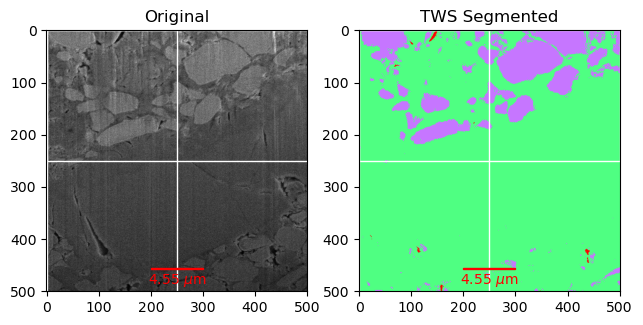

In [21]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")

plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();

In [22]:
def neighborhood_average(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mean(neighbors)
    return out


def neighborhood_mode(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mode(neighbors)[0][0]
    return out

# Features Matrix

# 2D Data
- Read image as data
- Apply Meijering filter to data
- Chained neighborhood average of data
    - dx = 10, dy = 10
    - dx = 10, dy = 10
    - dx = 5, dy = 5
    - dx = 5, dy = 5
- Scale data to [0, 1]
- Threshold scaled data

In [23]:
img_ = cv2.imread("../unsegmented/050.tif", cv2.IMREAD_UNCHANGED)
img_2 = filters.meijering(img_)

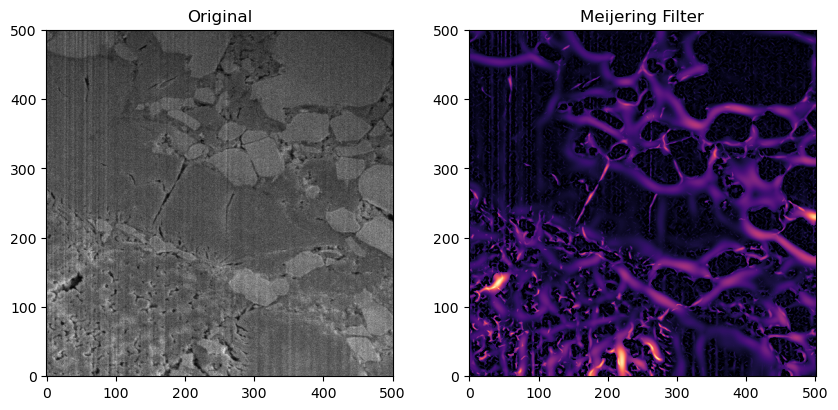

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_2, cmap='magma');
ax[1].invert_yaxis();
ax[1].set_title('Meijering Filter');

In [25]:
img_3 = neighborhood_average(img_2)
img_3 = neighborhood_average(img_3)
img_3 = neighborhood_average(img_3)
img_3 = neighborhood_average(img_3)
img = img_3 / np.max(img_3)

In [26]:
threshold = 0.075
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

# 3D Data

In [27]:
NX, NY = img_.shape
NZ = 202
threshold = 0.075
data_raw = np.zeros((NX, NY, NZ))
data = np.zeros((NX, NY, NZ))
for i in range(NZ):
    ii = str(i).zfill(3)
    img_0 = cv2.imread(f"../unsegmented/{ii}.tif", cv2.IMREAD_UNCHANGED)
    img_1 = filters.meijering(img_0)
    data[:, :, i] = img_1
    data_raw[:, :, i] = img_0

In [28]:
coords = np.argwhere(np.logical_and(np.greater_equal(data, 0), np.less_equal(data, threshold)))
y_3d = np.array([data[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_3d = np.hstack((coords, y_3d))

# HDBSCAN

# Optimal Threshold

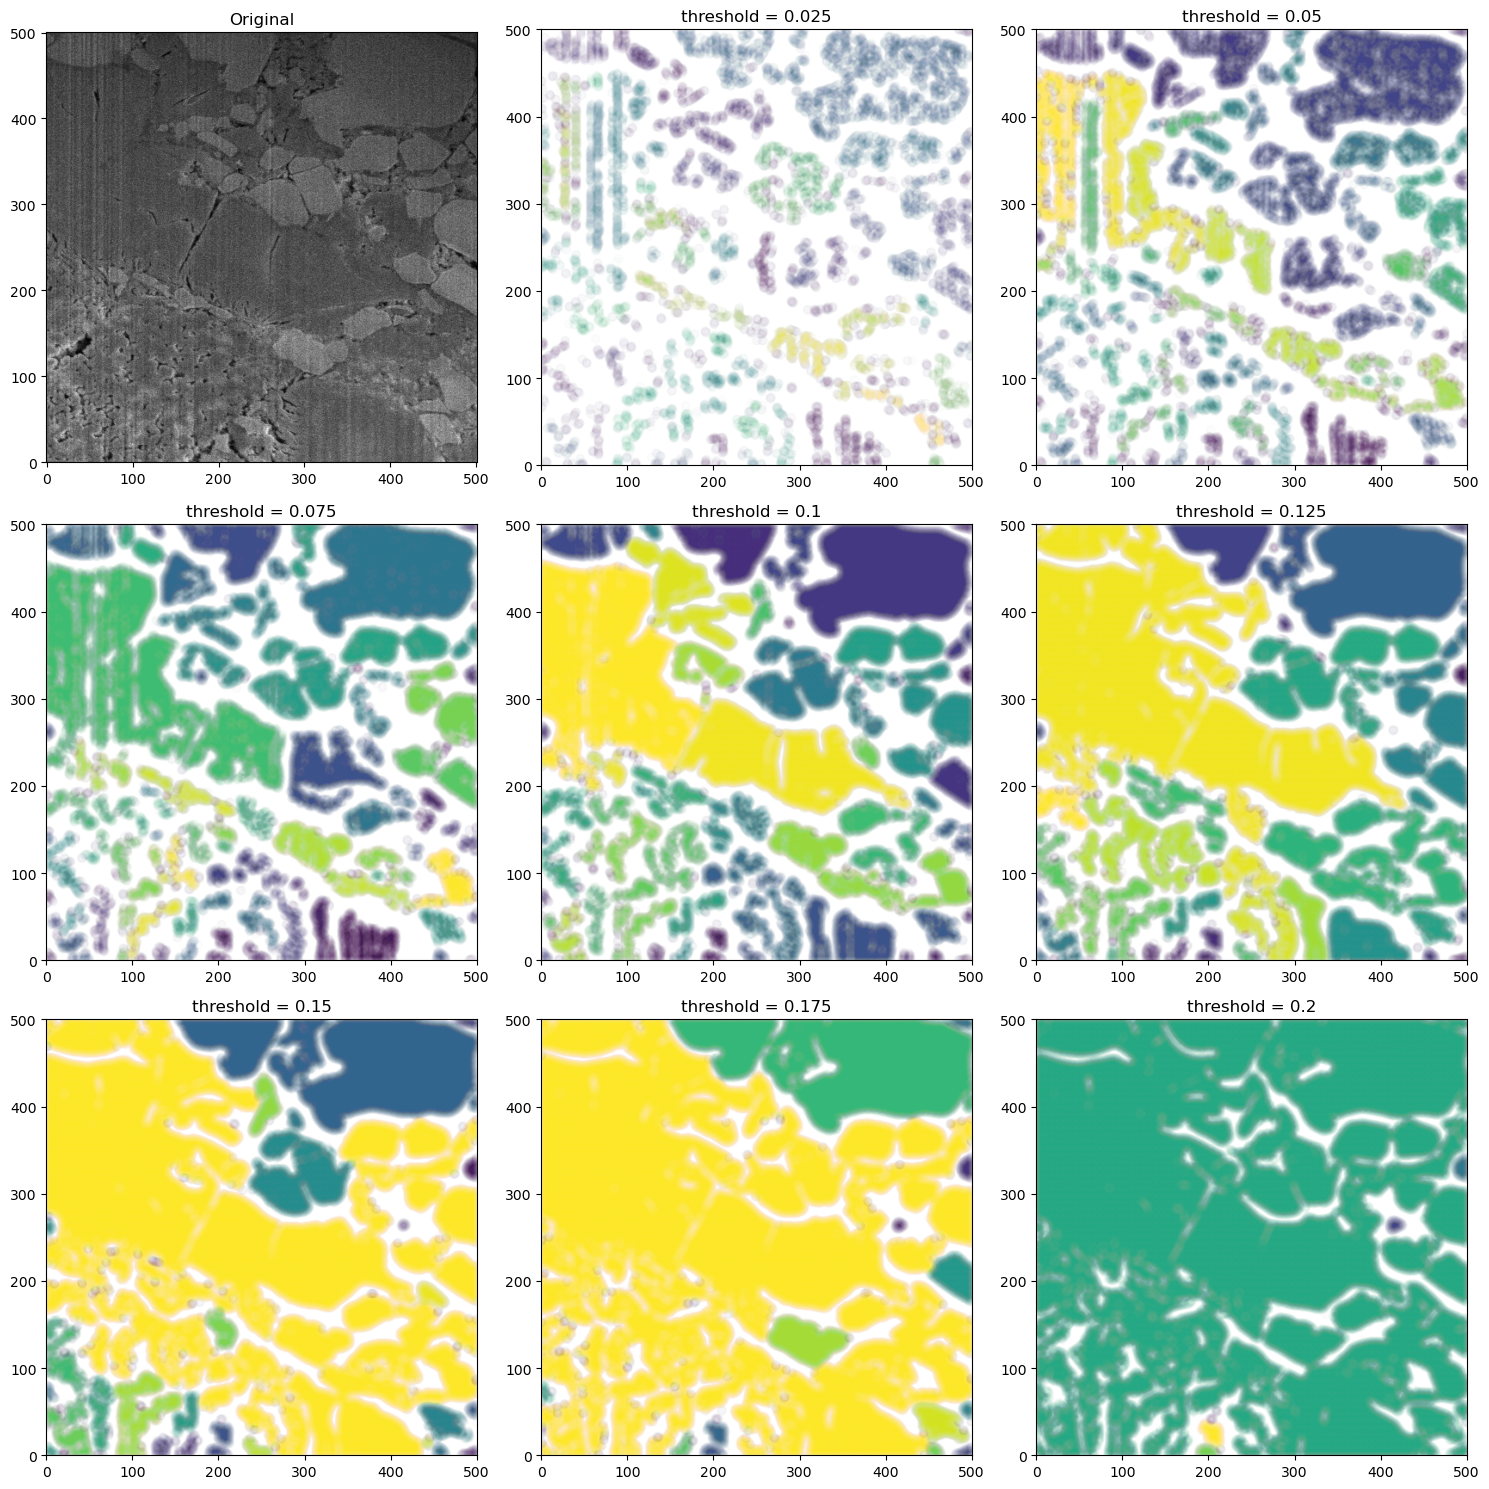

In [29]:
thresholds = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].imshow(img_, cmap='gray')
ax[0, 0].invert_yaxis();
ax[0, 0].set_title('Original');
for idx, threshold in enumerate(thresholds):
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=5, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # results
    ix = int((idx + 1) / 3)
    iy = (idx + 1) % 3
    ax[ix, iy].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
    ax[ix, iy].set_title(f"threshold = {threshold}");
    ax[ix, iy].set_xlim([0, 500]);
    ax[ix, iy].set_ylim([0, 500]);
plt.tight_layout();

# Segmentation
* Use optimal threshold to select feature points for clusters
* Identify clusters using hdbscan
* Backfill missing values in clusters to ensure dense cluster without small holes
* Use clusters to label training data
* Update training data with void clusters information
* Deploy model using the training data in order to predict the whole image

In [30]:
threshold = 0.075
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

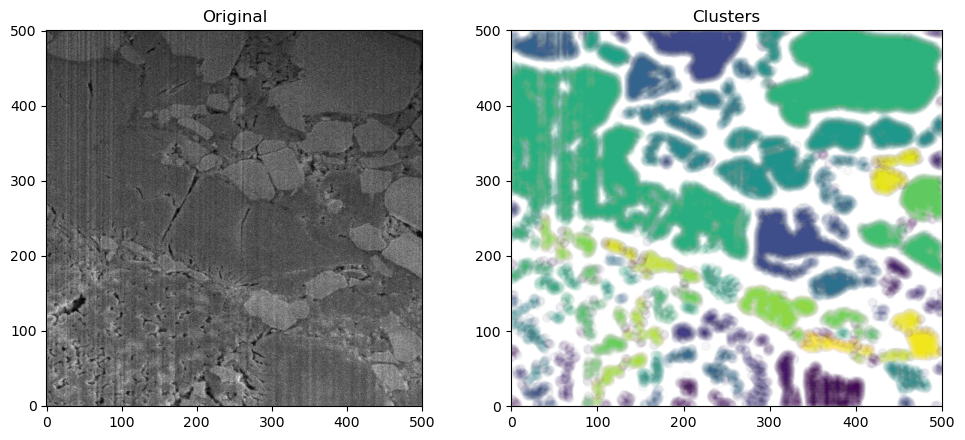

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

In [32]:
def load_clusters(X_2d, y_predict):
    img_seg = -2 * np.ones(img.shape)
    for v in np.unique(y_predict):
        X_v = np.argwhere(y_predict == v)
        coords = list(itertools.chain.from_iterable(X_v))
        for coord in coords:
            xx, yy = X_2d[int(coord), :2]
            img_seg[int(xx), int(yy)] = v
    return img_seg

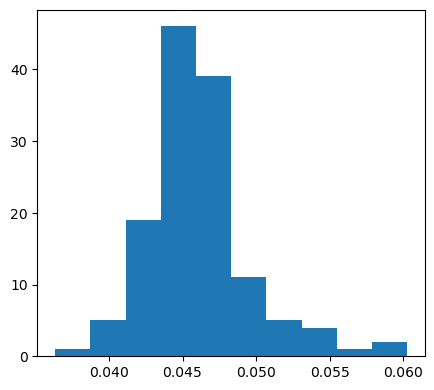

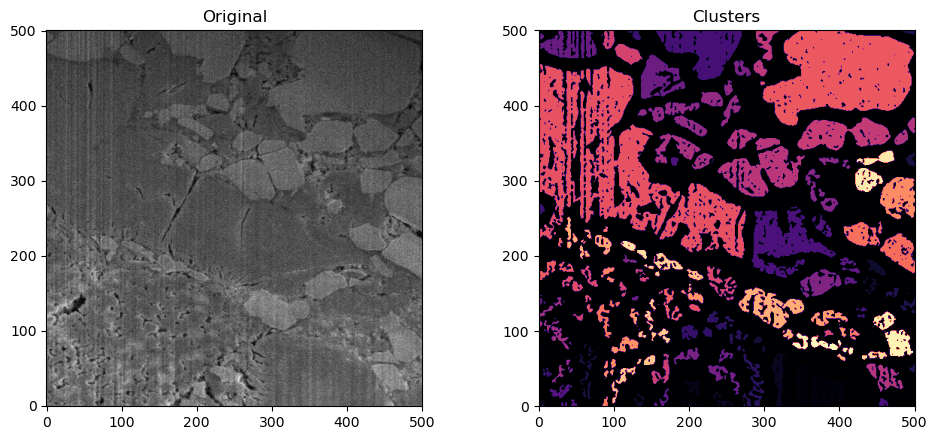

In [33]:
img_seg = -2 * np.ones(img.shape)

averages = []
fig, ax = plt.subplots(figsize=(5, 4.5))
for v in np.unique(y_predict):
    X_v = np.argwhere(y_predict == v)
    coords = list(itertools.chain.from_iterable(X_v))
    for coord in coords:
        xx, yy = X_2d[int(coord), :2]
        img_seg[int(xx), int(yy)] = v
    px_avg = np.mean(y[X_v])
    averages.append(px_avg)
ax.hist(averages, bins=10);
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

In [34]:
def enhance_clusters(img_seg):
    new_img = -2 * np.ones(img_seg.shape)
    for i in range(img_seg.shape[0]):
        for j in range(img_seg.shape[1]):
            v = img_seg[i, j]
            if v != -2:
                new_img[i, j] = v
                continue
            neighs = [
                (i, j + 1),
                (i + 1, j),
                (i, j - 1),
                (i - 1, j),
                (i + 1, j + 1),
                (i - 1, j - 1),
                (i - 1, j + 1),
                (i + 1, j - 1),
                ]
            vals = []
            for neigh in neighs:
                try:
                    vals.append(img_seg[neigh])
                except IndexError:
                    continue
            set_vals = set(vals)
            if -2 in set_vals:
                set_vals.remove(-2)
            if len(set_vals) == 1:
                new_img[i, j] = set_vals.pop()
    
    return new_img

-2.0 : 79468
-1.0 : 10811
1.0 : 3095
20.0 : 1765
28.0 : 5462
30.0 : 7039
40.0 : 2932
41.0 : 2977
47.0 : 1905
53.0 : 3384
61.0 : 1820
64.0 : 1565
66.0 : 6183
69.0 : 1913
70.0 : 2659
82.0 : 37979
84.0 : 19024
90.0 : 1899
91.0 : 1594
99.0 : 2477
109.0 : 3364


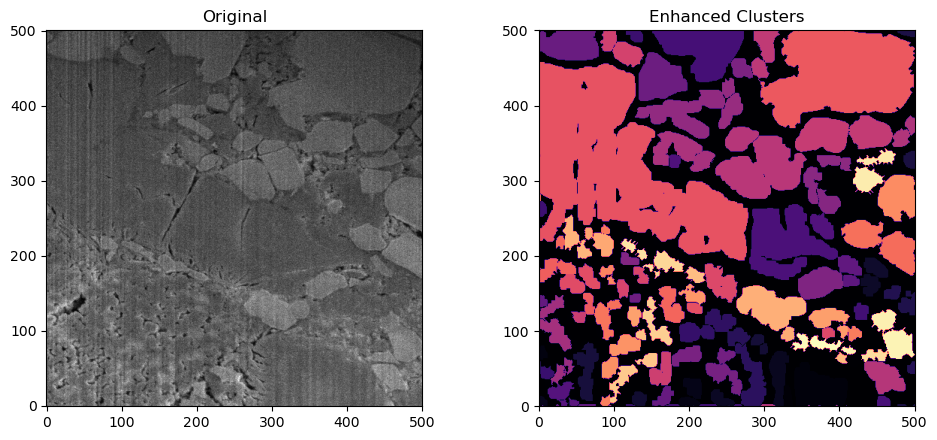

In [35]:
new_img = enhance_clusters(img_seg)
for i in range(2):
    new_img = enhance_clusters(new_img)
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(new_img, cmap='magma')
ax[1].set_title(f"Enhanced Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

for v in np.unique(new_img):
    len_cluster = len(np.argwhere(new_img == v))
    if len_cluster < 1500:
        continue
    print(v, ":", len_cluster)

In [36]:
# test_images = ['000.tif', '050.tif', '100.tif', '150.tif', '201.tif']
# test_data = -2 * np.ones((NX, NY, NZ))
# for test_image in test_images:
#     z = int(test_image.split('.')[0])
#     # input data
#     img_1 = cv2.imread("../unsegmented/" + test_image, cv2.IMREAD_UNCHANGED)
#     img_2 = filters.meijering(img_1)
#     img_3 = neighborhood_average(img_2)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img = img_3 / np.max(img_3)

#     # features
#     threshold = 0.075
#     coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
#     y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
#     X_2d = np.hstack((coords, y))

#     # hdbscan
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
#     y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

#     # enhance clusters
#     img_seg = load_clusters(X_2d, y_predict)
#     new_img = enhance_clusters(img_seg)
#     for i in range(2):
#         new_img = enhance_clusters(new_img)

#     # big enough clusters
#     clusters = []
#     for v in np.unique(new_img):
#         len_cluster = len(np.argwhere(new_img == v))
#         if v in (-1, -2):
#             continue
#         if len_cluster < 1500:
#             continue
#         clusters.append(v)

#         # plotting
#         fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
#         ax[0].imshow(img_1, cmap='gray')
#         ax[0].invert_yaxis();
#         ax[0].set_title(f'{z}: Original');
#         ax[1].imshow(new_img == v, cmap='magma');
#         ax[1].set_title(f'{z}: Cluster {v}');
#         ax[1].invert_yaxis();
#         plt.tight_layout();
#         plt.show();
#         phase = input('Enter phase: ')
#         test_data[np.argwhere(new_img == v), z] = phase